# Analysis of depth first traversal IO traces
This notebook contains scripts to analyse IO traces generated via `oak-run iotrace --trace DEPTH`. The io traces are looked up at `./depth-first/<access>/<state>/<cache>.csv`. 

* `<access>` is either `mmap` or `fileaccess` specifying whether the respective trace was collected with memory mapping enabled or disabled. 
* `<state>` is either `uncompacted` or `compacted` specifying whether the state of the traced repository. 
* `<cache` is an integer specifying the size of the segment cache (in MB) of the traced repository.

In addition this notebooks requires the files `./depth-first/tars-uncompacted.txt` and `./depth-first/tars-compacted.txt` containing all segmentIds of the respective repositories.

In [1]:
import turicreate as tc
import turicreate.aggregate as agg
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the list of segment ids
segments_nochanges = tc.SFrame('depth-first/segmentids-nochanges.csv')
segments_rewritenode = tc.SFrame('depth-first/segmentids-rewritenode-3.csv')

# Load the respective traces 
iotrace_nochanges = tc.SFrame('depth-first/iotrace-nochanges.csv')
iotrace_rewritenode = tc.SFrame('depth-first/iotrace-rewritenode-3.csv')

Finished parsing file /Users/axel/Documents/git/jackrabbit-oak/oak-segment-tar/depth-first/segmentids-nochanges.csv

Parsing completed. Parsed 100 lines in 0.031225 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/axel/Documents/git/jackrabbit-oak/oak-segment-tar/depth-first/segmentids-nochanges.csv

Parsing completed. Parsed 3163 lines in 0.011677 secs.

Finished parsing file /Users/axel/Documents/git/jackrabbit-oak/oak-segment-tar/depth-first/segmentids-rewritenode-3.csv

Parsing completed. Parsed 100 lines in 0.010671 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/axel/Documents/git/jackrabbit-oak/oak-segment-tar/depth-first/segmentids-rewritenode-3.csv

Parsing completed. Parsed 1764 lines in 0.01035 secs.

Unable to parse line "1536074168600,data00014a.tar,25c7eb93-a2e4-4884-a7c0-a076f02998be,150064,68073,"

Unable to parse line "1536074168608,data00000a.tar,da025091-6aaf-43e2-ac64-46745b79408c,624,6424,"

2 lines failed to parse correctly

Finished parsing file /Users/axel/Documents/git/jackrabbit-oak/oak-segment-tar/depth-first/iotrace-nochanges.csv

Parsing completed. Parsed 100 lines in 0.01462 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,str,int,int,int,int,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Unable to parse line "1536074168600,data00014a.tar,25c7eb93-a2e4-4884-a7c0-a076f02998be,150064,68073,"

Unable to parse line "1536074168608,data00000a.tar,da025091-6aaf-43e2-ac64-46745b79408c,624,6424,"

2 lines failed to parse correctly

Finished parsing file /Users/axel/Documents/git/jackrabbit-oak/oak-segment-tar/depth-first/iotrace-nochanges.csv

Parsing completed. Parsed 3160 lines in 0.014901 secs.

Unable to parse line "1536226611483,data00012a.tar,fc53d4ac-3e91-4815-a7ae-5f72d075f583,179296,60573,"

Unable to parse line "1536226611493,data00000a.tar,a0d37394-caec-4d1a-a121-1e4f922af198,262048,5730,"

Unable to parse line "1536226611498,data00012a.tar,9dc16ff4-7b6a-4b07-a921-6d1dbb33c645,93008,4639,"

3 lines failed to parse correctly

Finished parsing file /Users/axel/Documents/git/jackrabbit-oak/oak-segment-tar/depth-first/iotrace-rewritenode-3.csv

Parsing completed. Parsed 100 lines in 0.012153 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,str,int,int,int,int,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Unable to parse line "1536226611483,data00012a.tar,fc53d4ac-3e91-4815-a7ae-5f72d075f583,179296,60573,"

Unable to parse line "1536226611493,data00000a.tar,a0d37394-caec-4d1a-a121-1e4f922af198,262048,5730,"

Unable to parse line "1536226611498,data00012a.tar,9dc16ff4-7b6a-4b07-a921-6d1dbb33c645,93008,4639,"

3 lines failed to parse correctly

Finished parsing file /Users/axel/Documents/git/jackrabbit-oak/oak-segment-tar/depth-first/iotrace-rewritenode-3.csv

Parsing completed. Parsed 1761 lines in 0.011811 secs.

In [3]:
# A function to add a column `colName` with a sequence number to and SFrame `sframe`. 
# The sequence number starts at 1 and is incremented by one for each row.
def addSequenceNumber(sframe, colName):
    sframe[colName] = 1
    sframe[colName] = sframe[colName].cumulative_sum()

In [4]:
## Add sequence numbers to all SFrames
addSequenceNumber(segments_nochanges, 'wno')
addSequenceNumber(segments_rewritenode, 'wno')
addSequenceNumber(iotrace_nochanges, 'rno')
addSequenceNumber(iotrace_rewritenode, 'rno')

In [5]:
# Joint the io traces with the segment numbers and the total number of reads per segment
reads_nochanges = segments_nochanges.join(iotrace_nochanges, 'segmentId', 'inner').sort('wno')
read_rewritenode = segments_rewritenode.join(iotrace_rewritenode, 'segmentId', 'inner').sort('wno')

reads_nochanges_count = reads_nochanges.groupby('wno', operations={'access-count': agg.COUNT}).sort('wno')
read_rewritenode_count = read_rewritenode.groupby('wno', operations={'access-count': agg.COUNT}).sort('wno')

reads_nochanges = reads_nochanges.join(reads_nochanges_count, 'wno', 'inner')
read_rewritenode = read_rewritenode.join(read_rewritenode_count, 'wno', 'inner')

In [6]:
# reads in `oak:index`
reads_nochanges_i = reads_nochanges[reads_nochanges['path'].contains('oak:index')]
read_rewritenode_i = read_rewritenode[read_rewritenode['path'].contains('oak:index')]

# reads in `oak:index/reference`
reads_nochanges_r = reads_nochanges[reads_nochanges['path'].contains('oak:index/reference')]
read_rewritenode_r = read_rewritenode[read_rewritenode['path'].contains('oak:index/reference')]

# reads in `oak:index/uuid`
reads_nochanges_u = reads_nochanges[reads_nochanges['path'].contains('oak:index/uuid')]
read_rewritenode_u = read_rewritenode[read_rewritenode['path'].contains('oak:index/uuid')]

# reads in `jcr:system/jcr:versionStorage`
reads_nochanges_v = reads_nochanges[reads_nochanges['path'].contains('jcr:system/jcr:versionStorage')]
read_rewritenode_v = read_rewritenode[read_rewritenode['path'].contains('jcr:system/jcr:versionStorage')]

## Segments accessed per read operation

Scatter plot showing which segment (y axis) is read for each read operation (x-axis). Colours encoding certain sub-trees.

/Users/axel/python-3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


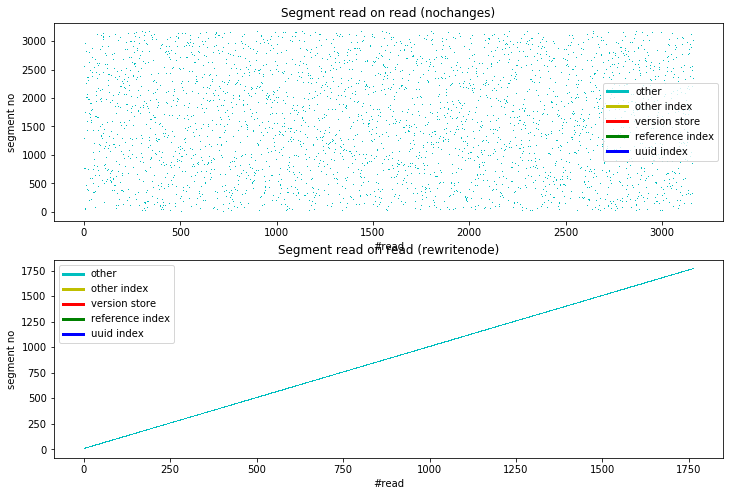

In [7]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.title('Segment read on read (nochanges)')
plt.xlabel("#read")
plt.ylabel("segment no")
plt.plot(reads_nochanges['rno'], reads_nochanges['wno'], ',c')
plt.plot(reads_nochanges_i['rno'], reads_nochanges_i['wno'], ',y')
plt.plot(reads_nochanges_v['rno'], reads_nochanges_v['wno'], ',r')
plt.plot(reads_nochanges_r['rno'], reads_nochanges_r['wno'], ',g')
plt.plot(reads_nochanges_u['rno'], reads_nochanges_u['wno'], ',b')
legend = plt.legend(['other', 'other index', 'version store', 'reference index', 'uuid index'])
for handle in legend.legendHandles:
    handle.set_linewidth(3)
    handle.set_linestyle("-")

    plt.subplot(2,1,2)
    plt.title('Segment read on read (rewritenode)')
    plt.xlabel("#read")
    plt.ylabel("segment no")
    plt.plot(read_rewritenode['rno'], read_rewritenode['wno'], ',c')
    plt.plot(read_rewritenode_i['rno'], read_rewritenode_i['wno'], ',y')
    plt.plot(read_rewritenode_v['rno'], read_rewritenode_v['wno'], ',r')
    plt.plot(read_rewritenode_r['rno'], read_rewritenode_r['wno'], ',g')
    plt.plot(read_rewritenode_u['rno'], read_rewritenode_u['wno'], ',b')
    legend = plt.legend(['other', 'other index', 'version store', 'reference index', 'uuid index'])
    for handle in legend.legendHandles:
        handle.set_linewidth(3)
        handle.set_linestyle("-")

Scatter plot showing which segment (y axis) is read for each read operation (x-axis). Colours encoding depth of the tree.

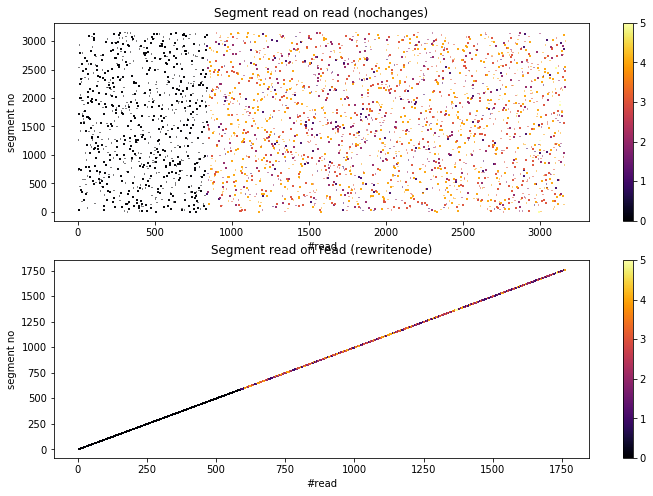

In [8]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.title('Segment read on read (nochanges)')
plt.xlabel("#read")
plt.ylabel("segment no")
plt.scatter(reads_nochanges['rno'], reads_nochanges['wno'], s=0.5, c=reads_nochanges['depth'], marker=',', cmap='inferno')
plt.colorbar()

plt.subplot(2,1,2)
plt.title('Segment read on read (rewritenode)')
plt.xlabel("#read")
plt.ylabel("segment no")
plt.scatter(read_rewritenode['rno'], read_rewritenode['wno'], s=0.5, c=read_rewritenode['depth'], marker=',', cmap='inferno')
plt.colorbar()

Scatter plot showing which segment (y axis) is read for each read operation (x-axis). Colours encoding number of times each segment is accessed.

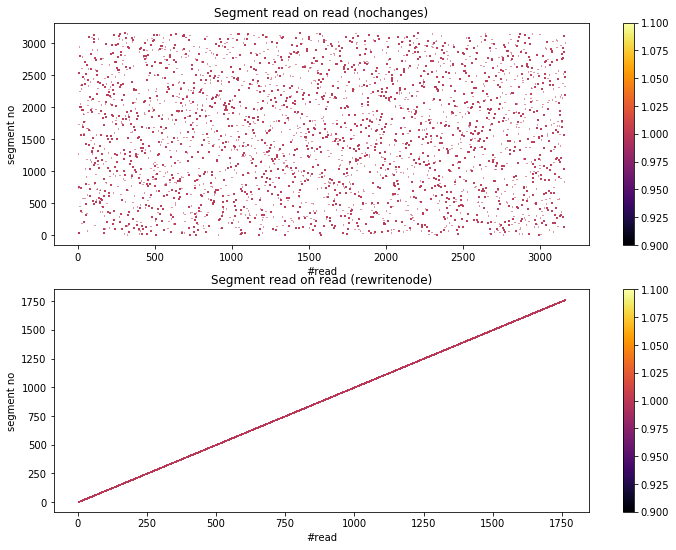

In [9]:
plt.figure(figsize=(12,9))
plt.subplot(2,1,1)
plt.title('Segment read on read (nochanges)')
plt.xlabel("#read")
plt.ylabel("segment no")
plt.scatter(reads_nochanges['rno'], reads_nochanges['wno'], s=0.5, c=reads_nochanges['access-count'], marker=',', cmap='inferno')
plt.colorbar()

plt.subplot(2,1,2)
plt.title('Segment read on read (rewritenode)')
plt.xlabel("#read")
plt.ylabel("segment no")
plt.scatter(read_rewritenode['rno'], read_rewritenode['wno'], s=0.5, c=read_rewritenode['access-count'], marker=',', cmap='inferno')
plt.colorbar()

Scatter plot showing for each segment (y-axis) how many time it was read (x-axis)

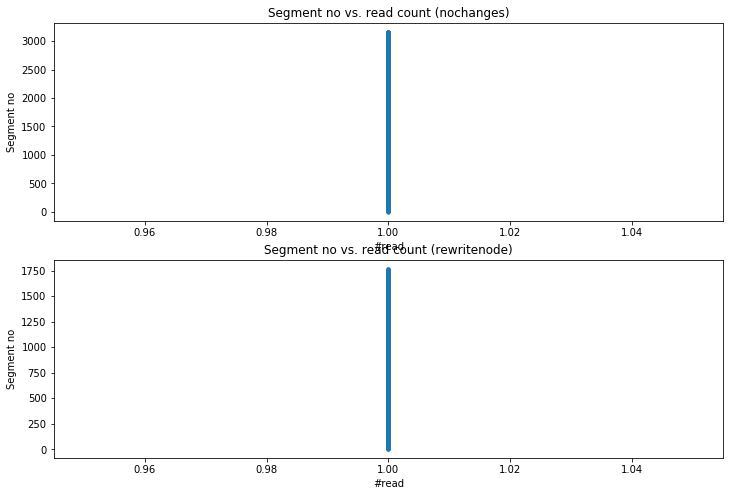

In [10]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.title('Segment no vs. read count (nochanges)')
plt.xlabel('#read')
plt.ylabel('Segment no')
plt.plot(reads_nochanges_count['access-count'], reads_nochanges_count['wno'], '.')

plt.subplot(2,1,2)
plt.title('Segment no vs. read count (rewritenode)')
plt.xlabel('#read')
plt.ylabel('Segment no')
plt.plot(read_rewritenode_count['access-count'], read_rewritenode_count['wno'], '.')

Plot of number of segments vs. number of times it the segment has beeen read

/Users/axel/python-3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


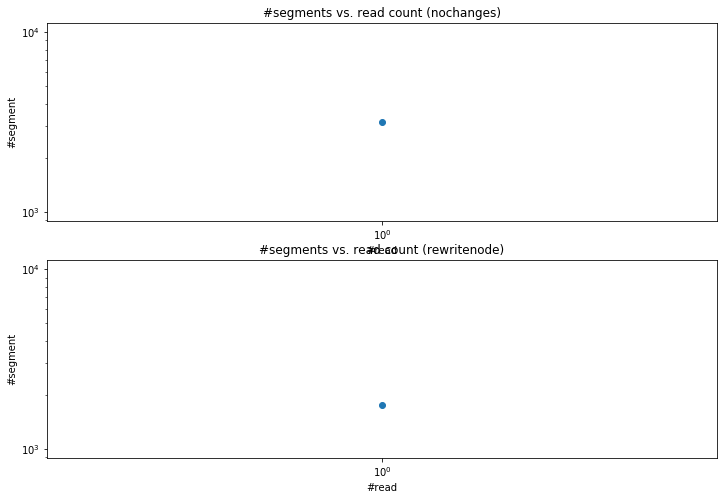

In [11]:
access_counts_u = reads_nochanges_count.groupby('access-count', operations={'segment-count': agg.COUNT}).sort('access-count')
access_counts_c = read_rewritenode_count.groupby('access-count', operations={'segment-count': agg.COUNT}).sort('access-count')

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.title("#segments vs. read count (nochanges)")
plt.xlabel('#read')
plt.ylabel('#segment')
plt.plot(access_counts_u['access-count'], access_counts_u['segment-count'], '-o')
plt.yscale('log')
plt.xscale('log')

plt.subplot(2,1,2)
plt.title("#segments vs. read count (rewritenode)")
plt.xlabel('#read')
plt.ylabel('#segment')
plt.plot(access_counts_c['access-count'], access_counts_c['segment-count'], '-o')
plt.yscale('log')
plt.xscale('log')